# Image Classification for Skins rashes and conditions

1. [Introduction](#Introduction)
2. [Postprocess the Output Manifest](#Postprocess-the-output-manifest)
3. [Plot class histograms](#Plott-class-histograms)
4. [Plot annotated images](#Plot-annotated-images)
  1. [Plot a small output sample](#Plot-a-small-output-sample)
  2. [Plot the full results](#Plot-the-full-results)

## Introduction
This Jupyter notebook analysis the output of labeling for image classification of skin conditions and rashes. The training dataset is classified into 11 classes: namely chicken pox, cold sores, dermatitis, fifth disease, eczema, measles, impetigo, hive, baby acne, heat rash, and scarlet fever. 

In [11]:
!conda install --yes --prefix /home/ec2-user/anaconda3 -c conda-forge scikit-plot

Solving environment: done

# All requested packages already installed.



In [18]:
%matplotlib inline

import os
import json
import random
from collections import namedtuple
from collections import Counter

import imageio
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
from matplotlib.backends.backend_pdf import PdfPages


## Postprocess the output manifest
First, we will download the output manifest manfiest (please provide its S3 path in the cell below). Next, we will postprocess it to form four arrays:
* `img_uris` contains the S3 URIs of all the images that Ground Truth annotated.
* `labels` contains Ground Truth's labels for each image in `img_uris`.
* `confidences` contains the confidence of each label in `labels`.
* `human` is a flag array that contains 1 at indices corresponding to images annotated by human annotators, and 0 at indices corresponding to images annotated by Ground Truth's automated data labeling.

In [45]:
# Load the output manifest's annotations.
OUTPUT_MANIFEST = 's3://sciencemit/train.manifest' # Replace with the S3 URI for your output manifest.
!aws s3 cp {OUTPUT_MANIFEST} 'train.manifest'

with open('output.manifest', 'r') as f:
    output = [json.loads(line.strip()) for line in f.readlines()]

# Create data arrays.
img_uris = [None] * len(output)
confidences = np.zeros(len(output))
labels = [None] * len(output)
human = np.zeros(len(output))

# Find the job name the manifest corresponds to.
keys = list(output[0].keys())
metakey = keys[np.where([('-metadata' in k) for k in keys])[0][0]]
jobname = metakey[:-9]

# Extract the data.
for datum_id, datum in enumerate(output):
    img_uris[datum_id] = datum['source-ref']
    labels[datum_id] = datum[metakey]['class-name']
    confidences[datum_id] = datum[metakey]['confidence']
    human[datum_id] = int(datum[metakey]['human-annotated'] == 'yes')
labels = np.array(labels)

download: s3://sciencemit/train.manifest to ./train.manifest    


## Plot class histograms
Now, let's plot the class histograms. The next cell should produce three subplots:
* The Left subplot shows the number of images annotated as belonging to each visual category. The categories will be sorted from the most to the least numerous. Each bar is divided into a 'human' and 'machine' part which shows how many images were annotated as given category by human annotators and by the automated data labeling mechanism.

* The Middle subplot is the same as Left, except y-axis is in log-scale. This helps visualize unbalanced datasets where some categories contain orders of magnitude more images than other.

* The Right subplot shows the average confidence of images in each category, separately for human and auto-annotated images.

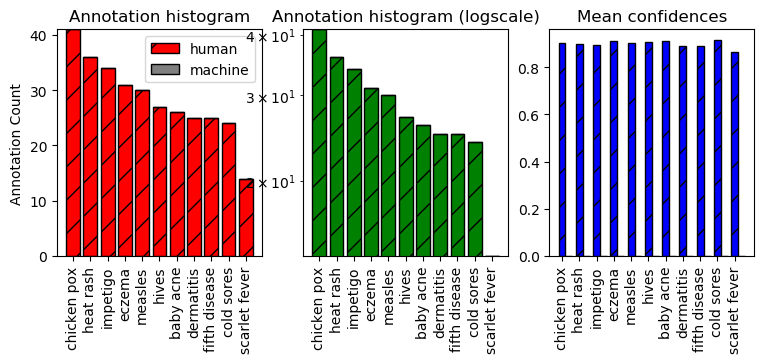

In [46]:
# Compute the number of annotations in each class.
n_classes = len(set(labels))
sorted_clnames, class_sizes = zip(*Counter(labels).most_common(n_classes))

# Find ids of human-annotated images.
human_sizes = [human[labels == clname].sum() for clname in sorted_clnames]
class_sizes = np.array(class_sizes)
human_sizes = np.array(human_sizes)

# Compute the average annotation confidence per class.
human_confidences = np.array([confidences[np.logical_and(labels == clname, human)]
                              for clname in sorted_clnames])
machine_confidences = [confidences[np.logical_and(labels == clname, 1-human)]
                       for clname in sorted_clnames]

# If there is no images annotated as a specific class, set the average class confidence to 0.
for class_id in range(n_classes):
    if human_confidences[class_id].size == 0:
        human_confidences[class_id] = np.array([0])
    if machine_confidences[class_id].size == 0:
        machine_confidences[class_id] = np.array([0])

plt.figure(figsize=(9, 3), facecolor='white', dpi=100)
plt.subplot(1, 3, 1)
plt.title('Annotation histogram')
plt.bar(range(n_classes), human_sizes, color='red', hatch='/', edgecolor='k', label='human')
plt.bar(range(n_classes), class_sizes - human_sizes, bottom=human_sizes, color='gray', edgecolor='k', label='machine')
plt.xticks(range(n_classes), sorted_clnames, rotation=90)
plt.ylabel('Annotation Count')
plt.legend()

plt.subplot(1, 3, 2)
plt.title('Annotation histogram (logscale)')
plt.bar(range(n_classes), human_sizes, color='green', hatch='/', edgecolor='k', label='human')
plt.bar(range(n_classes), class_sizes - human_sizes, bottom=human_sizes, color='gray', edgecolor='k', label='machine')
plt.xticks(range(n_classes), sorted_clnames, rotation=90)
plt.yscale('log')

plt.subplot(1, 3, 3)
plt.title('Mean confidences')
plt.bar(np.arange(n_classes), [conf.mean() for conf in human_confidences],
        color='blue', hatch='/', edgecolor='k', width=.4)
plt.bar(np.arange(n_classes) + .4, [conf.mean() for conf in machine_confidences],
        color='red', edgecolor='k', width=.4)
plt.xticks(range(n_classes), sorted_clnames, rotation=90);

## Plot annotated images
In any data science task, it is crucial to plot and inspect the results to check they make sense. In order to do this, we will 
1. Download the input images that Ground Truth annotated.
2. Split them by annotated category and whether the annotation was done by human or the auto-labeling mechanism.
3. Plot images in each category and human/auto-annoated class.

We will download the input images to `LOCAL_IMAGE_DIR` you can choose in the next cell. Note that if this directory already contains images with the same filenames as your Ground Truth input images, we will not re-download the images.

If your dataset is large and you do not wish to download and plot **all** the images, simply set `DATASET_SIZE` to a small number. We will pick a random subset of your data for plotting.

In [47]:
LOCAL_IMG_DIR = './dataset' # Replace with the name of a local directory to store images.
DATASET_SIZE = len(img_uris) # Change this to a reasonable number if your dataset much larger than 10K images.

subset_ids = np.random.choice(range(len(img_uris)), DATASET_SIZE, replace=False)
img_uris = [img_uris[idx] for idx in subset_ids]

labels = labels[subset_ids]
confidences = confidences[subset_ids]
human = human[subset_ids]

img_fnames = [None] * len(output)
for img_uri_id, img_uri in enumerate(img_uris):
    target_fname = os.path.join(
        LOCAL_IMG_DIR, img_uri.split('/')[-1])
    if not os.path.isfile(target_fname):
        !aws s3 cp {img_uri} {target_fname}
    img_fnames[img_uri_id] = target_fname
    
import scikitplot as skplt
import matplotlib.pyplot as plt


### Plot a small output sample
The following cell will create two figures. The first plots `N_SHOW` images in each category, as annotated by humans. 
If any category contains less than `N_SHOW` images, that row will not be displayed. By default, `N_SHOW = 10`, but feel free to change this to any other small number.

0.76
0.95
0.92
0.78
0.9
0.91
0.93
0.9
0.94
0.94
0.76
0.95
0.92
0.78
0.9
0.91
0.93
0.9
0.94
0.94
0.76
0.95
0.92
0.78
0.9
0.91
0.93
0.9
0.94
0.94
0.76
0.95
0.92
0.78
0.9
0.91
0.93
0.9
0.94
0.94
0.76
0.95
0.92
0.78
0.9
0.91
0.93
0.9
0.94


ValueError: Could not find a format to read the specified file in mode 'i'

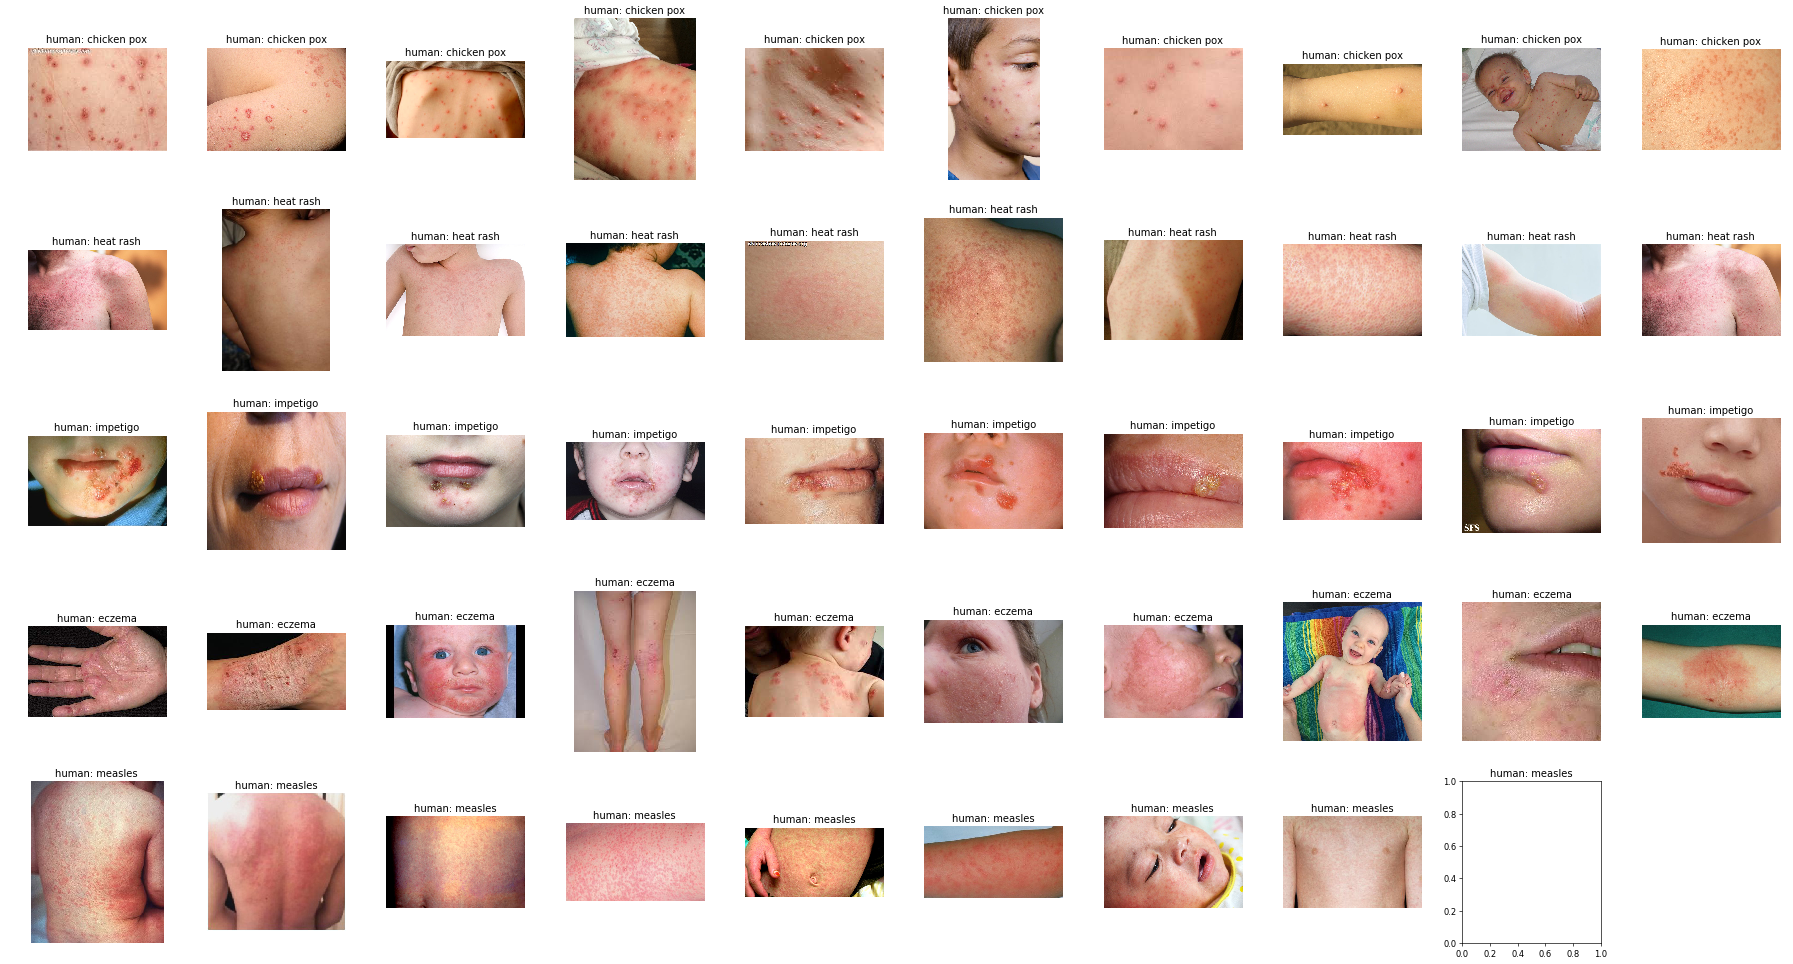

In [50]:
N_SHOW = 10

plt.figure(figsize=(3 * N_SHOW, 2 + 3 * n_classes), facecolor='white', dpi=60)
for class_name_id, class_name in enumerate(sorted_clnames):
    class_ids = np.where(np.logical_and(np.array(labels) == class_name, human))[0]
    try:
        show_ids = np.random.choice(class_ids, N_SHOW, replace=False)
    except ValueError:
        print('Not enough human annotations to show {}'.format(class_name))
        continue
    for show_id_id, show_id in enumerate(show_ids):
        print (confidences[show_id_id])
        plt.subplot2grid((n_classes, N_SHOW), (class_name_id, show_id_id))
        plt.title('human: ' + class_name)
        plt.imshow(imageio.imread(img_fnames[show_id]))
        plt.axis('off')
    plt.tight_layout()
    

### Plot the full results
Finally, we plot all the results to a large pdf file. The pdf (called `ground_truth.pdf`) will display 100 images per page. Each page will contain images belonging to the same category, and annotated either by human annotators or by the auto-labeling mechanism. You can use this pdf to investigate exactly which images were annotated as which class at a glance.

This might take a while, and the resulting pdf might be very large. For a dataset of 1K images, the process takes only a minute and creates a 10MB-large pdf. You can set `N_SHOW_PER_CLASS` to a small number if you want to limit the max number of examples shown in each category.

In [17]:
N_SHOW_PER_CLASS = np.inf
plt.figure(figsize=(10, 10), facecolor='white', dpi=100)

with PdfPages('ground_truth.pdf') as pdf:
    for class_name in sorted_clnames:
        # Plot images annotated as class_name by humans.
        plt.clf()
        plt.text(0.1, 0.5, s='Images annotated as {} by humans'.format(class_name), fontsize=20)
        plt.axis('off')
        
        class_ids = np.where(np.logical_and(np.array(labels) == class_name, human))[0]
        for img_id_id, img_id in enumerate(class_ids):
            if img_id_id == N_SHOW_PER_CLASS:
                break
            if img_id_id % 100 == 0:
                pdf.savefig()
                plt.clf()
                print('Plotting annotations of {}, {}/{}...'.format(
                    class_name, img_id_id, min(len(class_ids), N_SHOW_PER_CLASS)))
            plt.subplot(10, 10, (img_id_id % 100) + 1)
            try: 
                plt.imshow(imageio.imread(img_fnames[img_id]), aspect='auto')
            except:
                continue
            plt.axis('off')
        pdf.savefig()
        
        
        # Plot images annotated as class_name by machines.
        # plt.clf()
        # plt.text(0.1, 0.5, s='Images annotated as {} by machines'.format(class_name), fontsize=20)
        # plt.axis('off')
        
        # class_ids = np.where(np.logical_and(np.array(labels) == class_name, 1-human))[0]
        # for img_id_id, img_id in enumerate(class_ids):
        #    if img_id_id == N_SHOW_PER_CLASS:
        #        break
        #    if img_id_id % 100 == 0:
        #        pdf.savefig()
        #        plt.clf()
        #        print('Plotting machine annotations of {}, {}/{}...'.format(
        #           class_name, img_id_id, min(len(class_ids), N_SHOW_PER_CLASS)))
        #    plt.subplot(10, 10, (img_id_id % 100) + 1)
        #    plt.imshow(imageio.imread(img_fnames[img_id]), aspect='auto')
        #    plt.axis('off')
        # pdf.savefig()
plt.clf()

Plotting annotations of chicken pox, 0/41...
Plotting annotations of heat rash, 0/36...
Plotting annotations of impetigo, 0/34...
Plotting annotations of eczema, 0/31...
Plotting annotations of measles, 0/30...
Plotting annotations of hives, 0/27...
Plotting annotations of baby acne, 0/26...
Plotting annotations of dermatitis, 0/25...
Plotting annotations of fifth disease, 0/25...
Plotting annotations of cold sores, 0/24...
Plotting annotations of scarlet fever, 0/14...


<Figure size 1000x1000 with 0 Axes>

In [38]:
from sklearn.metrics import confusion_matrix
import numpy as np




cm = confusion_matrix(labels, confidences)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
np.mean(recall)
np.mean(precision)

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [39]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(labels, confidences, average='macro')

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets